# Deux conteneurs
## sysbench oltp : 2GB vs 1GB
### Tester la soft limite
#### Description
Le but de cette expérience est de simuler le gain obtenu si la `soft` limite d'un conteneur ayant de bonnes performances était diminuée pour essayer d'augmenter les performances de l'autre conteneur.

On se place dans un scénario où deux conteneurs (A et B) exécutant les mêmes charges de travail (`sysbench oltp` en lecture seule) sont lancés mais avec des bases de données de tailles différentes (2GB contre 1GB). Les conteneurs s'exécutent 120 secondes.

Plusieurs configurations de `soft` limites seront étudiées :
* 2GB pour le conteneur A et 1GB pour le conteneur B.
* 2.5GB pour le conteneur A et .5GB pour le conteneur B.
* 2.3GB pour le conteneur A et .7GB pour le conteneur B.
* 2.3GB pour le conteneur A et 1.3GB pour le conteneur B.


#### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 4 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Chaque conteneur est lancé avec une `max` limite fixée à 3GB et chaque conteneur dispose de deux coeurs. Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

#### Résultats attendus
Selon les différentes configurations les résultats devraient être les suivants :
1. Aucun conteneur ne devrait s'exécuter de manière acceptable car leurs `soft` limites sont inférieures à leurs empreintes mémoires idéales.
2. Le conteneur A devrait avoir de bonnes performances au détriment du conteneur B.
3. Le conteneur A devrait avoir de bonnes performances (peut-être moindres que dans le deuxième cas) au désavantage du conteneur B (ses performances seront peut-être meilleures que dans le deuxième cas).
4. Aucun conteneur ne devrait s'exécuer de manière convenable car le noyau ne peut pas privilégier un conteneur par rapport à l'autre.

#### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Avant chaque expérience une sauvegarde de la base de données est effectuée afin de ramener celle-ci de force en mémoire et donc de gonfler la mémoire du conteneur.
Cette sauvegarde ramenera les données dans le cache fichier du noyau. Ainsi pour accèder à ces données `mysql` n'aura qu'à faire une copie de celles-ci depuis le cache fichier vers son tampon mémoire plutôt que ramener celles-ci depuis le disque.
Cette sauvegarde émule en quelque sorte le fait que `mysql` s'exécute depuis longtemps et à ramener toute la base de données dans sa mémoire.

Le script permettant de lancer plusieurs conteneurs en même temps et d'obtenir des statistiques sur ceux-ci est le suivant (une version ne lançant qu'un conteneur a aussi été écrite) :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>
import sys
import docker
import os
import threading
import json
import time

"""This python script will start two containers with filebench with the given as
argument soft limits.

It will then run 10 times the SYSBENCH_CONTAINER_A and SYSBENCH_CONTAINER_B in
each container as argument. The output of filebench will be written to a file
and statistics (memory usage in bytes and reads from the disk) will be written
to another file.
"""

# Each run lasts 120 seconds.
DURATION = 120

# Sysbench commands for the container A and B.
# Container A's db will be 2G and that of B will be 1G. Each will execute with
# two threads since they have 2 cores.
SYSBENCH_PREPARE_COMMANDS = ['sysbench --threads=2 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 prepare', 'sysbench --threads=2 /usr/share/sysbench/oltp_read_only.lua --table_size=5000000 prepare']
SYSBENCH_RUN_COMMANDS = ['sysbench --time=%d --threads=2 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run' % DURATION, 'sysbench --time=%d --threads=2 /usr/share/sysbench/oltp_read_only.lua --table_size=5000000 run' % DURATION]

# This command is run before each run to force read the whole database and bring
# it in memory.
# WARNING We can not use redirection directly in exec_run. We need to use bash
# to be able to redirect. Thanks Damien for the information and also the
# suggestion of the command.
MYSQL_DUMP_COMMAND = "bash -c 'mysqldump sbtest > /dev/null'"

# Give two virtual core to each container. The virtual core are chosen so they
# are on the same physical core (i.e cache are shared).
CONTAINERS_CPUS_SETS = ['0,2', '1,3']

CHARS = ['A', 'B']

# The keys added to a temporary dictionary.
KEYS = ['Usage', 'io_serviced_recursive:Read', 'io_service_bytes_recursive:Read']

# 'io_serviced_recursive' gives the number of read, write, etc. while
# 'io_service_bytes_recursive' gives the number of bytes read, written, etc.
IO_KEYS = ['io_serviced_recursive', 'io_service_bytes_recursive']

def thread_func(container, command, out, stats):
	"""Run the command in container and write the output in out.
	This function will be used as a thread.
	:param container: The container in which command will be run. It must already
	been started.
	:type container: docker.models.containers.Container
	:param command: The command to run in container.
	:type command: str
	:param out: An open in write file object where the output of command will be
	written.
	:type out: _io.TextIOWrapper
	:param out: An open in write file object where the stats of the container will
	be written.
	:type out: _io.TextIOWrapper
	"""
	container.exec_run(MYSQL_DUMP_COMMAND)

	gen = container.stats()

	# Run the benchmark inside the container and write the output to out.
	# exec_run returns a tuple whom second field contains bytes. The decode
	# translate them to a string.
	out.write(container.exec_run(command)[1].decode('utf-8') + '\n')

	statistics = []
	old_values = {}

	# old_values will be used below, this loop initializes it with 0s and
	# with the good keys.
	for i in KEYS[1:]:
		old_values[i] = 0

	for record in gen:
		# Translate the record in string and translate it to python dictionary.
		# Vive la Joz' ! Bon vivant Docteur bon vivant !
		jason = json.loads(record.decode('utf-8'))

		# Create a new dictionary at each iteration so the statistics's cases are
		# differents.
		chicandier = {'Usage': jason['memory_stats']['usage']}

		for key in IO_KEYS:
			for io in jason['blkio_stats'][key]:
				if io['op'] == 'Read':
					# Reconstruct the key with the jason key and the op.
					true_key = key + ':' + io['op']

					# Get the difference between this iteration and the previous one.
					# The value is the number of read or write for this second. It can be
					# seen as the bandwith.
					val = io['value'] - old_values[true_key]

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_values[true_key] = io['value']

					# Little trick if the key is not already present.
					# TODO Maybe this if is useless since this code is called each second
					# and chicandier is recreate each second. But it works and I will no
					# loose some time for a little if...
					if true_key in chicandier:
						chicandier[true_key] += val
					else:
						chicandier[true_key] = val

		statistics.append(chicandier)

		# Our filebenches last DURATION seconds so we just want DURATION
		# records since containerd give stats every second.
		if len(statistics) == DURATION:
			break

	# Add the statistics to the stat file.
	for i in range(len(statistics)):
		stats.write('%d' % i)

		# Write each statistics in order.
		for key in KEYS:
			stats.write(';%d' % statistics[i][key])

		stats.write('\n')

def main():
	containers = []
	outs = []
	stats = []

	if len(sys.argv) != 3:
		sys.exit("Usage: %s soft_limit0 soft_limit1" % sys.argv[0])

	client = docker.from_env()

	for i in range(len(sys.argv) - 1):
		# Launch containers as detached.
		containers.append(client.containers.run('sysbench', auto_remove = True, detach = True, mem_limit = '3G'))

	# Wait 30 seconds so the sysbench container is ready. Indeed, it can be slow
	# because mysql is long to boot.
	time.sleep(30)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run each benchmark once so they are prepared.
	for i in range(len(containers)):
		containers[i].exec_run(SYSBENCH_PREPARE_COMMANDS[i])

		# Set the container limits once its preparation phase is finished.
		# sys.argv[i + 1] because sys.argv[0] is the program name and there are
		# len(sys.argv) - 1 containers.
		containers[i].update(mem_reservation = sys.argv[i + 1], mem_limit = '3G', memswap_limit = '3G', cpuset_cpus = CONTAINERS_CPUS_SETS[i])

		# Drop the cache so the preparation above does not have a consequence on the
		# runs below.
		drop_cache.write(bytearray('3\n', 'utf-8'))

		outs.append(open(os.path.expanduser('~/container_%c_%s_%s.out' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))
		stats.append(open(os.path.expanduser('~/container_%c_%s_%s.stats' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))

		stats[i].write('iteration;usage;reads;read_bandwith\n')

	# Run each filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		threads = []

		for j in range(len(containers)):
		# Prepare the threads which will run filebench inside the containers.
			threads.append(threading.Thread(target = thread_func, args = (containers[j], SYSBENCH_RUN_COMMANDS[j], outs[j], stats[j])))

		# Launch the threads.
		for t in threads:
			t.start()

		# Wait them.
		for t in threads:
			t.join()

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	for i in range(len(containers)):
		containers[i].stop()

		outs[i].close()
		stats[i].close()

	drop_cache.close()

if __name__ == "__main__":
    main()
```

Ces scripts ont ensuite été exécutés depuis un script bash qui gère les différentes configuration de `soft` limite qui ont été listées dans la description :
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>

python3 test_soft_limit.py 2000M 1000M
echo 'Finished run 2G/1G!'
python3 test_soft_limit.py 2500M 500M
echo 'Finished run 2.3G/.7G!'
python3 test_soft_limit.py 2300M 700M
echo 'Finished run 2.3G/.7G!'
python3 test_soft_limit.py 2300M 1300M
echo 'Finished run 2.3G/1.3G!'
```

#### Résultats obtenus
Les deux conteneurs sont lancés ensemble et exécutent leurs charges de travail ensemble. Les résultats obtenus sont les suivants :

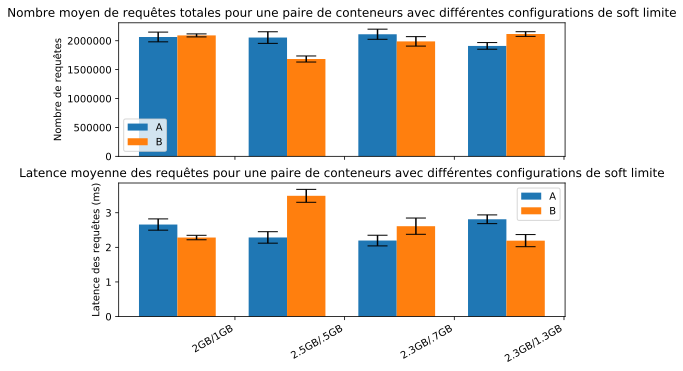

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'vanilla'
FILES = {'A': ['container_A_dreamy_meninsky_2000M.out.csv', 'container_A_hardcore_shamir_2500M.out.csv', 'container_A_youthful_nightingale_2300M.out.csv', 'container_A_nostalgic_kilby_2300M.out.csv'], 'B': ['container_B_distracted_colden_1000M.out.csv', 'container_B_wonderful_lamarr_500M.out.csv', 'container_B_inspiring_liskov_700M.out.csv', 'container_B_elastic_noether_1300M.out.csv']}

# xtick labels for the bar chart.
NAMES = ['2GB/1GB', '2.5GB/.5GB', '2.3GB/.7GB', '2.3GB/1.3GB']
# The width of the bars.
WIDTH = .35

dictionnary = {}

for key in FILES:
    dictionnary[key] = {'request': {'mean': [], 'std': []}, 'latency': {'mean': [], 'std': []}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        # Computing mean and standard deviation.
        # values is a numpy.ndarray i.e an array of tuples.
        # mean() and std() take an axis as argument and return a tuple.
        # [1] permits to obtain second member of tuple.
        dictionnary[key]['request']['mean'].append(values.mean(0)[1])
        dictionnary[key]['request']['std'].append(values.std(0)[1])
    
        dictionnary[key]['latency']['mean'].append(values.mean(0)[2])
        dictionnary[key]['latency']['std'].append(values.std(0)[2])

x_pos = np.arange(len(NAMES))

# Axis and figure initialization.
fig, (request_ax, latency_ax) = plt.subplots(nrows = 2, figsize = (8, 6))

request_groups = []
latency_groups = []

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    request_groups.append(request_ax.bar(x_pos, dictionnary[key]['request']['mean'], WIDTH, yerr = dictionnary[key]['request']['std'], align = 'center', capsize = 10))
    latency_groups.append(latency_ax.bar(x_pos, dictionnary[key]['latency']['mean'], WIDTH, yerr = dictionnary[key]['latency']['std'], align = 'center', capsize = 10))         

    # Shift the position the second bar by width.
    x_pos = x_pos + WIDTH
    
request_ax.set_ylabel('Nombre de requêtes')
request_ax.set_xticks(x_pos)
request_ax.set_xticklabels(NAMES)
request_ax.legend(request_groups, sorted_keys)
request_ax.set_title("Nombre moyen de requêtes totales pour une paire de conteneurs avec différentes configurations de soft limite")

latency_ax.set_ylabel('Latence des requêtes (ms)')
latency_ax.set_xticks(x_pos)
latency_ax.set_xticklabels(NAMES)
latency_ax.legend(latency_groups, sorted_keys)
latency_ax.set_title("Latence moyenne des requêtes pour une paire de conteneurs avec différentes configurations de soft limite")

fig.autofmt_xdate()
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

La latence et le nombre de requêtes se corrèlent bien dans le sens où une latence élevée implique moins de requêtes effectuées.

Les résultats obtenus ne sont pas forcémment conformes aux résultats attendus mais peuvent être expliqués:
1. `sysbench oltp` lit la base de donnée de manière uniforme par conséquent il n'y a pas de seuil à partir duquel ses performances se dégrade violemment. Ici les `soft limites` des conteneurs leur permettent d'avoir de bonnes performances.
2. Comme attendu les performances de A sont meilleures que celles de B. A gâche donc .5GB puisque ses performances sont semblables à celles qu'il obtient dans le premier cas.
3. Comme attendu les performances de A sont meilleures que celles de B. B a de meilleures performances que dans le deuxième cas.
4. Les deux conteneurs ont des performances acceptables mais A s'exécute moins bien que B.

Étudions l'empreinte mémoire de chaque conteneur et les lectures qu'ils font depuis le disque pour mieux comprendre leurs performances.

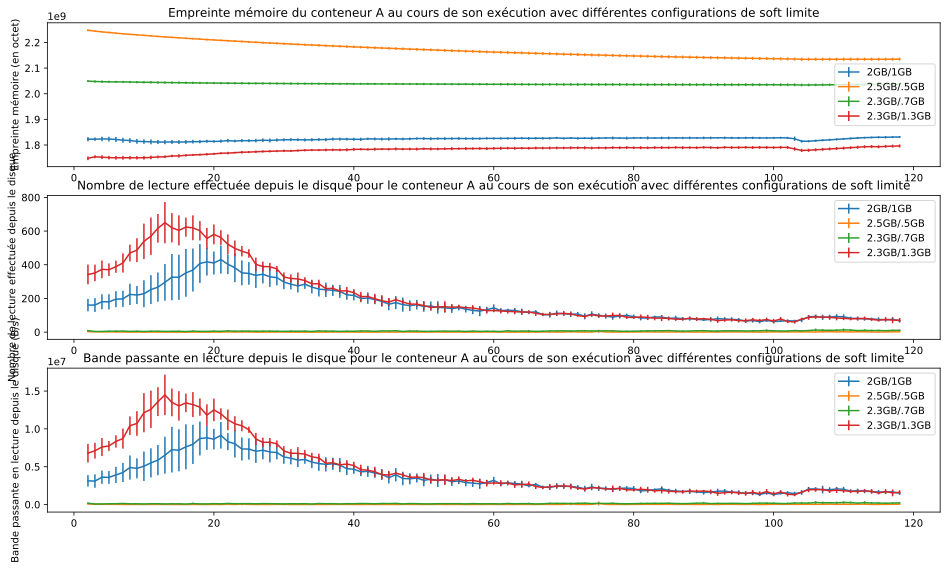

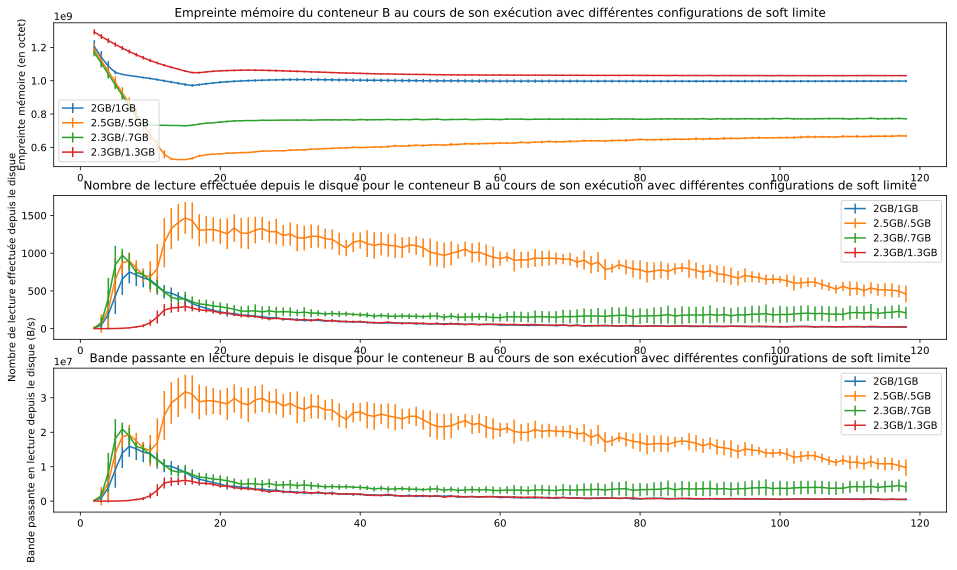

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

NAMES = ['2GB/1GB', '2.5GB/.5GB', '2.3GB/.7GB', '2.3GB/1.3GB']

DIR = 'vanilla'
FILES = {'A': ['container_A_dreamy_meninsky_2000M.stats.csv', 'container_A_hardcore_shamir_2500M.stats.csv', 'container_A_youthful_nightingale_2300M.stats.csv', 'container_A_nostalgic_kilby_2300M.stats.csv'], 'B': ['container_B_distracted_colden_1000M.stats.csv', 'container_B_wonderful_lamarr_500M.stats.csv', 'container_B_inspiring_liskov_700M.stats.csv', 'container_B_elastic_noether_1300M.stats.csv']}

DURATION = 120

dictionnary = {}

for key in FILES:
    dictionnary[key] = {'usage': {'means': [], 'stds': []}, 'reads': {'means': [], 'stds': []}, 'read_bw': {'means': [], 'stds': []}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        # The first record has strange standard deviation values so we do not get it.
        dictionnary[key]['usage']['means'].append(values.take(1, axis = 1)[2 : len(values) - 1])
        dictionnary[key]['usage']['stds'].append(values.take(2, axis = 1)[2 : len(values) - 1])

        dictionnary[key]['reads']['means'].append(values.take(3, axis = 1)[2 : len(values) - 1])
        dictionnary[key]['reads']['stds'].append(values.take(4, axis = 1)[2 : len(values) - 1])

        dictionnary[key]['read_bw']['means'].append(values.take(5, axis = 1)[2 : len(values) - 1])
        dictionnary[key]['read_bw']['stds'].append(values.take(6, axis = 1)[2 : len(values) - 1])

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    fig, (usage_ax, reads_ax, read_bw_ax) = plt.subplots(nrows = 3, figsize = (16, 9))
    for i in range(len(NAMES)):
        usage_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['usage']['means'][i], yerr = dictionnary[key]['usage']['stds'][i], label = NAMES[i])
        reads_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['reads']['means'][i], yerr = dictionnary[key]['reads']['stds'][i], label = NAMES[i])
        read_bw_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['read_bw']['means'][i], yerr = dictionnary[key]['read_bw']['stds'][i], label = NAMES[i])
        
        usage_ax.legend()
        usage_ax.set_ylabel('Empreinte mémoire (en octet)')
        usage_ax.set_title('Empreinte mémoire du conteneur %c au cours de son exécution avec différentes configurations de soft limite' % key)

        reads_ax.legend()
        reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
        reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur %c au cours de son exécution avec différentes configurations de soft limite' % key)

        read_bw_ax.legend()
        read_bw_ax.set_ylabel('Bande passante en lecture depuis le disque (B/s)')
        read_bw_ax.set_title('Bande passante en lecture depuis le disque pour le conteneur %c au cours de son exécution avec différentes configurations de soft limite' % key)
        
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Détaillons les résultats obtenus dans l'ordre des cas étudiés :
1. Le conteneur A voit son empreinte mémoire limitée par sa `soft limite` il effectue donc des lectures depuis le disque (avec un pic à 400) même si ce nombre tend à diminuer au cours de son exécution. Le conteneur B a une bonne empreinte mémoire et n'effectue donc pas beaucoup de lecture au cours de son exécution (il y a un pic au début mais après ce nombre se tasse).
2. Le conteneur A a une excellente empreinte mémoire inférieure à sa `soft limite`. Il ne sera donc pas réclamé et n'effectue donc aucune lecture. La mémoire du conteneur B est limité par le noyau et se fixe à .6GB par conséquent il effectuera tout au long de son exécution beaucoup de lecture depuis le disque (environ 1000 par secondes).
3. Ce cas est un mix entre le deuxième cas pour le conteneur A et le premier cas pour le conteneur B.
4. Le noyau n'arrive pas à satisfaire les deux `soft limites`. Le conteneur B voit son empreinte mémoire se fixer à 1GB ce qui représente une bonne empreinte mémoire pour lui donc il n'effectue pas beaucoup de lecture depuis le disque au cours de son exécution. Par contre le conteneur A a une mauvaise empreinte mémoire, il va donc effectuer beaucoup de lecture (on peut voir un pic à 600 lectures) mais ce nombre diminue une fois le pic passé.

Les brusques pics de lecture pendant les premières secondes d'exécution des conteneurs sont dûs au fait qu'à cause de la limite mémoire certaines données doivent être cherchées depuis le disque. Une fois que ces données sont ramenées dans la mémoire il n'y a plus besoin d'aller les chercher d'où la décroissance.

Le deuxième cas est intéressant car on peut voir que le conteneur A gâche virtuellement .3GB (son empreinte mémoire est d'environ 2.2GB et sa `soft limite` est fixée à 2.5GB). La `soft limite` de B aurait donc pu être augmentée de .3GB sans gêner le conteneur A tout en augmentant les performances du conteneur B.

#### Conclusion
Cette expérience a un comportement plus réaliste que les expériences basées sur `filebench`.
Néanmoins le deuxième cas montre toujours le même problème : si la `soft limite` d'un conteneur est supérieure à la taille de son *working set* alors la différence entre ces deux valeurs est gâchée.
Il est donc possible de récupérer cette mémoire gâchée pour la donner à un autre conteneur.